In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
import keras
import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.


In [3]:
tf_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True), log_device_placement=True)

In [4]:
in_columns = ['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']
out_columns = ['S0x0', 'S0x1', 'S0x2', 'S0x3', 'S0x4', 'S3x0', 'S3x1',
       'S2x0', 'S2x1', 'S2x2', 'S2x3', 'S0x5', 'S0x6', 'S0x7', 'S0x8', 'S0x9',
       'S0x10', 'S1x0', 'S1x1', 'S1x2', 'S1x3', 'S1x4', 'S1x5', 'S5x0', 'S4x0',
       'S4x1', 'S4x2', 'S3x2', 'S4x3', 'S4x4', 'S5x1', 'S5x2', 'S5x3', 'S5x4',
       'S4x5']
BATCH_SIZE = int(1e4)
IN_DIM = len(in_columns)
OUT_DIM = len(out_columns)
LATENT_DIMENSIONS = 20
TEST_SIZE = 0.5

In [5]:
def split_and_scale(data):
    data_train, data_val = train_test_split(data, test_size=TEST_SIZE, random_state=42)
    scaler = RobustScaler().fit(data_train)

    data_train = pd.DataFrame(scaler.transform(data_train.values),
                              columns=data_train.columns)
    data_val = pd.DataFrame(scaler.transform(data_val.values),
                            columns=data_val.columns)
    data_val, data_test = train_test_split(data_val, test_size=TEST_SIZE, random_state=1812)
    return data_train, data_val, data_test, scaler

In [6]:
data_train, data_val, _, _ = split_and_scale(pd.read_csv("./Data/LHCb_PID_obscured.csv").drop("pid", axis=1))

In [7]:
data_train = data_train[in_columns+out_columns]
data_val = data_val[in_columns+out_columns]

In [8]:
len(data_train)

1636152

In [9]:
data_train = data_train[:1000000]
data_val = data_val[:500000]

In [10]:
def get_tf_dataset(dataset, batch_size):
    shuffler = tf.contrib.data.shuffle_and_repeat(dataset.shape[0])
    suffled_ds = shuffler(tf.data.Dataset.from_tensor_slices(dataset))
    return suffled_ds.batch(batch_size).prefetch(1).make_one_shot_iterator().get_next()

In [11]:
tf.reset_default_graph()

In [12]:
def get_dense(num_layers):
    return [ll.Dense(128, activation='relu') for i in range(num_layers)]

CRAMER_DIM = 256

critic = keras.models.Sequential(
        [ll.InputLayer([OUT_DIM + IN_DIM])] + get_dense(7) +
            [ll.Dense(CRAMER_DIM)])
generator = keras.models.Sequential(
        [ll.InputLayer([LATENT_DIMENSIONS + IN_DIM])] + get_dense(7) +
            [ll.Dense(OUT_DIM)])

In [13]:
X_train_full = data_train[in_columns+out_columns]
X_train_input = data_train[in_columns]

X_train_input_tf1 = get_tf_dataset(X_train_input, BATCH_SIZE)
X_train_input_tf2 = get_tf_dataset(X_train_input, BATCH_SIZE)
X_train_full_tf = get_tf_dataset(X_train_full, BATCH_SIZE)

In [14]:
def cramer_critic(x, y):
    discriminated_x = critic(x)
    return tf.norm(discriminated_x - critic(y), axis=1) - tf.norm(discriminated_x, axis=1)

In [15]:
noise_1 = tf.random_normal([tf.shape(X_train_input_tf1)[0], LATENT_DIMENSIONS], name='noise1')
noise_2 = tf.random_normal([tf.shape(X_train_input_tf2)[0], LATENT_DIMENSIONS], name='noise2')

generated_out_1 = generator(tf.concat([noise_1, tf.cast(X_train_input_tf1, tf.float32)], axis=1))
generated_full_1 = tf.concat([tf.cast(X_train_input_tf1, tf.float32), generated_out_1], axis=1)

generated_out_2 = generator(tf.concat([noise_2, tf.cast(X_train_input_tf2, tf.float32)], axis=1))
generated_full_2 = tf.concat([tf.cast(X_train_input_tf2, tf.float32), generated_out_2], axis=1)

In [16]:
generator_loss = tf.reduce_mean(cramer_critic(tf.cast(X_train_full_tf, tf.float32), generated_full_2)
                                - cramer_critic(generated_full_1, generated_full_2))

In [17]:
with tf.name_scope("gradient_loss"):
    alpha = tf.random_uniform(shape=[tf.shape(X_train_full_tf)[0], 1], minval=0., maxval=1.)
    interpolates = alpha*tf.cast(X_train_full_tf, tf.float32) + (1.-alpha)*generated_full_1
    disc_interpolates = cramer_critic(interpolates, generated_full_2)
    gradients = tf.gradients(disc_interpolates, [interpolates])[0]
    slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
    gradient_penalty = tf.reduce_mean(tf.square(tf.maximum(tf.abs(slopes) - 1, 0)))

In [18]:
tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
lambda_tf = 20 / np.pi * 2 * tf.atan(tf.cast(tf_iter, tf.float32)/1e4)
critic_loss = lambda_tf*gradient_penalty - generator_loss
learning_rate = tf.train.exponential_decay(1e-3, tf_iter, 1000, 0.98)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
critic_train_op = optimizer.minimize(critic_loss, var_list=critic.trainable_weights)
generator_train_op = tf.group(
    optimizer.minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

In [19]:
tf.summary.scalar("critic_loss", tf.reshape(critic_loss, []))
tf.summary.scalar("generator_loss", tf.reshape(generator_loss, []))
tf.summary.scalar("learning_rate", learning_rate)
tf.summary.scalar("lambda", lambda_tf)
merged_summary = tf.summary.merge_all()

In [20]:
N_VAL = int(3e5)
validation_np = data_val.sample(N_VAL).values

In [21]:
data_val.sample(N_VAL).head()

,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,S0x0,S0x1,S0x2,S0x3,S0x4,...,S4x1,S4x2,S3x2,S4x3,S4x4,S5x1,S5x2,S5x3,S5x4,S4x5
406790,1.443170,1.130696,0.0,0.0,-1000.0,-0.143366,-0.581429,-0.238132,-0.569657,0.0,...,0.212758,0.0,0.246003,0.169743,-0.000067,-4011.635621,-1.170993,-6.614150,-999.0,0.721140
1136668,-0.000515,0.198665,0.0,0.0,0.0,-0.207274,-0.582629,-0.159445,-0.545584,0.0,...,0.104860,0.0,-0.211784,2.405499,0.000475,0.006405,1.599646,1.276623,1.0,0.476888
1283010,-0.420120,0.109524,-1000.0,-1000.0,0.0,0.599842,0.000000,1.468266,0.000000,0.0,...,-0.898830,-1.0,-0.589835,-0.428971,-0.999402,-0.643843,3.825858,1.531182,1.0,-0.424289
1581281,-0.172632,0.527481,0.0,0.0,-1000.0,-0.390647,-0.478491,0.591772,-0.448068,0.0,...,0.090250,0.0,-0.211784,1.924394,0.000638,-4011.635621,-1.170993,-6.614150,-999.0,1.144383
1230702,-0.540239,-1.290512,0.0,-1000.0,0.0,-0.757271,0.000000,0.414546,0.000000,0.0,...,-0.898830,-1.0,-0.173138,-0.428971,-0.999402,0.320334,6.065339,-0.154814,0.0,-0.424289


In [22]:
var_init = tf.global_variables_initializer()
weights_saver = tf.train.Saver()

In [23]:
tf.get_default_graph().finalize()

In [24]:
MODEL_NAME = "GAN_Kramer_bs104_l7_ld20"
LOGDIR = "/mnt/tgaintseva/compression/tensorboard_logdir"
CRITIC_ITERATIONS_CONST = 15
CRITIC_ITERATIONS_VAR = 0
TOTAL_ITERATIONS = int(1e5)
VALIDATION_INTERVAL = 100
MODEL_WEIGHTS_FILE = "weights/%s.ckpt" % MODEL_NAME
train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
test_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "test"))
critic_policy = lambda i: (
    CRITIC_ITERATIONS_CONST + (CRITIC_ITERATIONS_VAR * (TOTAL_ITERATIONS - i)) // TOTAL_ITERATIONS)

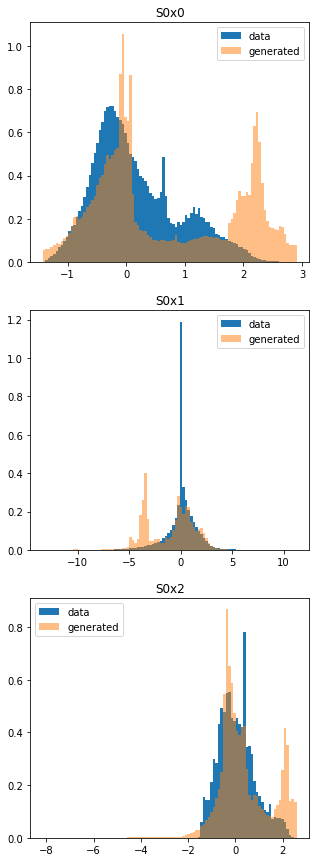

KeyboardInterrupt: 

In [25]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    for i in range(TOTAL_ITERATIONS):
        for j in range(critic_policy(i)):
            sess.run(critic_train_op)
        train_summary, _, interation = sess.run([merged_summary, generator_train_op, tf_iter])
        train_writer.add_summary(train_summary, interation)
        if i % VALIDATION_INTERVAL == 0:
            clear_output(False)
            test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
                X_train_input_tf1: validation_np[:, :len(in_columns)],
                X_train_input_tf2: validation_np[:, :len(in_columns)], X_train_full_tf: validation_np})
            test_writer.add_summary(test_summary, interation)
            weights_saver.save(sess, MODEL_WEIGHTS_FILE)
            fig, axes = plt.subplots(3, 1, figsize=(5, 15))
            for INDEX, ax in zip((0, 1, 2), axes):
                _, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
                ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
                ax.legend()
                ax.set_title(out_columns[INDEX])
            plt.show()

INFO:tensorflow:Restoring parameters from weights/GAN_Kramer_bs104_l7_ld20.ckpt


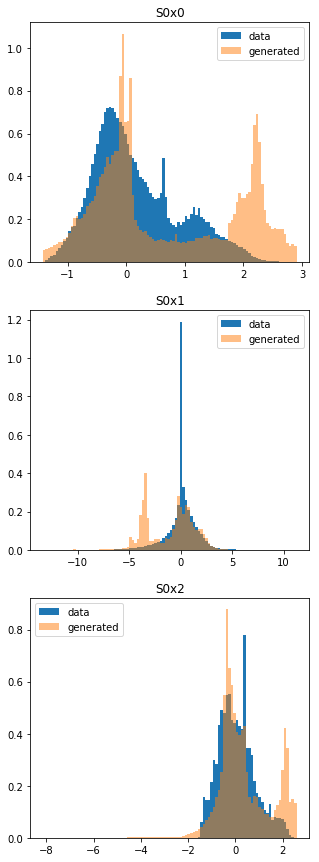

In [26]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
        X_train_input_tf1: validation_np[:, :len(in_columns)],
        X_train_input_tf2: validation_np[:, :len(in_columns)], X_train_full_tf: validation_np})
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    for INDEX, ax in zip((0, 1, 2), axes):
        _, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
        ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
        ax.legend()
        ax.set_title(out_columns[INDEX])
    plt.show()

In [25]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    sess.graph._unsafe_unfinalize()
    tf.get_default_graph().finalize()

INFO:tensorflow:Restoring parameters from weights/GAN_Kramer_bs104_l7_ld20.ckpt


In [26]:
import os
import json
import shutil

In [27]:
import xgboost as xgb
from IPython import display
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score, accuracy_score

In [28]:
# Save
def _transform_val(v):
    if isinstance(v, dict):
        return {kk: list(vv) if isinstance(vv, np.ndarray) else vv 
                for kk, vv in v.items()}
    elif isinstance(v, np.ndarray):
        return list(v)
    else:
        return v
    
def dump(saved_dict, folder, name):
    """ Save a 'saved_dict' to .json in 'folder' with 'name'.
    
    Params
    ------
        saved_dict : dict, {'encoding_dim' : [metric_value, ...]} or 
                           {'pid_label' : {'encoding_dim' : [metric_value, ...]} }
            Dict of a metric. 
    """
    dict_for_json = {k: _transform_val(v) for k, v in saved_dict.items()}
    with open(os.path.join(folder, name + ".json"), 'w', encoding="utf-8") as file:
        # writing
        json.dump(dict_for_json, file, indent=4, ensure_ascii=False)
    del dict_for_json


def get_last_dir_n(path_to_metrics, metrics_dir_name):
    """ Return the highest number of folders which name == number"""
    try:
        last_folder_n = max(list(map(lambda name: int(name.split('_')[-1]), 
                                     filter(lambda name: os.path.isdir(os.path.join(path_to_metrics, name)) 
                                            and name.split('_')[-1].isdecimal(), os.listdir(path_to_metrics)))))
    except:
        last_folder_n = None
        
    return last_folder_n


def create_metrics_folder(path_to_metrics, metrics_dir_name):
    """ Create new folder for metrics in 'metrics_path' dir.
    Return
    ------
        new_folder : str
            Path to new folder.
        old_folder : str
            Path to prev folder.
    """
    last_folder_n = get_last_dir_n(path_to_metrics, metrics_dir_name)
    if last_folder_n is None:
        new_folder = os.path.join(path_to_metrics, metrics_dir_name + '_0')
        old_folder = None
    else:
        new_folder = os.path.join(path_to_metrics, metrics_dir_name + '_' + str(last_folder_n + 1))
        old_folder = os.path.join(path_to_metrics, metrics_dir_name + '_' + str(last_folder_n))
    os.makedirs(new_folder)
    
    return new_folder, old_folder


def dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict):
    """ Save all metrics from 'metrics_dict' to .json files.
        Save in 'path_to_metrics' + 'metrics_dir_name' + '_' + str(version) dir 
        to new folder and delete prev version.
        
    Params
    ------    
        metrics_dict : dict, {'metric_name' :  {'encoding_dim' : [metric_value, ...]}} or
                             {'metric_name' :  {'pid_label' : {'encoding_dim' : [metric_value, ...]} }}
            Dict of dicts for all metrics.
    """
    folder, old_folder = create_metrics_folder(path_to_metrics, metrics_dir_name)
    print(folder)

    for metric_name, metric_values in metrics_dict.items():
        dump(metric_values, folder, metric_name)
    
    if old_folder is not None:
        shutil.rmtree(old_folder, ignore_errors=True)

In [29]:
# Load
def load_metrics(path_to_metrics, metrics_dir_name):
    """
    Return
    ------    
        metrics_dict : dict, {'metric_name' :  {'encoding_dim' : [metric_value, ...]}} or
                             {'metric_name' :  {'pid_label' : {'encoding_dim' : [metric_value, ...]} }}
            Dict of dicts for all metrics.
    """
    metrics_dict = {}
    last_folder_n = get_last_dir_n(path_to_metrics, metrics_dir_name)
    folder = os.path.join(path_to_metrics, metrics_dir_name + '_' + str(last_folder_n))
    for file_name in filter(lambda name: name.endswith('.json'), os.listdir(folder)):
        with open(os.path.join(folder, file_name), 'r') as file:
            metrics_dict[file_name[:-5]] = json.load(file)
    return metrics_dict

In [30]:
def plot_roc_auc(fpr, tpr, roc_auc, f_measure, acc, pid_label=0, xlim=(0, 1), ylim=(0, 1),
                 title='Receiver operating characteristic'):
    plt.figure()
    lw = 2
    l_colors= ['darkorange', 'blue', 'red', 'green', 'black', 'yellow']
    for i, encoding_dim in enumerate(fpr.keys()):
        plt.plot(
            fpr[encoding_dim][pid_label], tpr[encoding_dim][pid_label], color=l_colors[i], lw=lw, 
            label="{} ROC AUC {:.3}, F {:.3}, Acc {:.3}".format(
                encoding_dim, roc_auc[encoding_dim][pid_label], 
                f_measure[encoding_dim], acc[encoding_dim]
            )
        )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title(title)
    plt.savefig("./img/ROC_{}.png".format(TYPE))
    plt.show()

In [31]:
def plot_metrics(metrics_dict, pid_label=0, xlim=(0, 1), ylim=(0, 1)):
    plt.figure(figsize=(15, 7))
    lw = 2
    l_colors= ['darkorange', 'blue', 'red', 'green', 'black', 'yellow']
    # ROC AUC
    plt.subplot(1, 2, 1)
    for i, encoding_dim in enumerate(metrics_dict['fpr'].keys()):
        plt.plot(
            metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], 
            color=l_colors[i], lw=lw, 
            label="{} ROC AUC {:.3}, F {:.3}, Acc {:.3}".format(
                encoding_dim, metrics_dict['roc_auc'][encoding_dim][pid_label], 
                metrics_dict['f_measure'][encoding_dim], metrics_dict['acc'][encoding_dim]
            )
        )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title("ROC AUC")
    #plt.savefig("./img/ROC_{}_xlim_{}_ylim_{}.png".format(TYPE, xlim, ylim))
    
    # PR AUC
    plt.subplot(1, 2, 2)
    for i, encoding_dim in enumerate(metrics_dict['precision'].keys()):
        plt.plot(
            metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], 
            color=l_colors[i], lw=lw, 
            label="{} PR AUC {:.3}, F {:.3}, Acc {:.3}".format(
                encoding_dim, metrics_dict['pr_auc'][encoding_dim][pid_label], 
                metrics_dict['f_measure'][encoding_dim], metrics_dict['acc'][encoding_dim]
            )
        )
    plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(loc="lower left")
    plt.title("PR AUC")
    #plt.savefig("./img/PR_{}_xlim_{}_ylim_{}.png".format(TYPE, xlim, ylim))
    plt.show()

In [32]:
data = pd.read_csv("./Data/LHCb_PID_obscured.csv")
data_train, data_val = train_test_split(data, test_size=0.5, random_state=42)

train_pid = data_train['pid']
val_pid = data_val['pid']

In [33]:
scaler = RobustScaler().fit(data_train.drop("pid", axis=1))

data_train = pd.DataFrame(scaler.transform(data_train.drop("pid", axis=1).values),
                          columns=data_train.drop("pid", axis=1).columns)
data_val = pd.DataFrame(scaler.transform(data_val.drop("pid", axis=1).values),
                        columns=data_val.drop("pid", axis=1).columns)

In [34]:
data_train['pid'] = np.array(train_pid)
data_val['pid'] = np.array(val_pid)

In [35]:
data_val, data_test = train_test_split(data_val, test_size=0.5, random_state=1812)
data_val_input = data_val[['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']] 
data_test_input = data_test[['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']] 

In [37]:
data_val_full = data_val[in_columns+out_columns]
data_test_full = data_test[in_columns+out_columns]

In [38]:
pid_input = data_val_input['pid']
pid_test = data_test_input["pid"]

In [39]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
                X_train_input_tf1: data_test_input.drop("pid", axis=1),
                X_train_input_tf2: data_test_input.drop("pid", axis=1), X_train_full_tf: data_test_full})

In [40]:
le = LabelEncoder()
y = le.fit_transform(pid_test)

In [41]:
metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

In [42]:
path_to_metrics = './metrics/'
metrics_dir_name = MODEL_NAME

In [44]:
test_size = 0.3

idx_train_clf, idx_test_clf = train_test_split(np.arange(data_test_full.shape[0]), stratify=y, 
                                               random_state=42, test_size=test_size)
X_train, X_test = np.array(data_test_full)[idx_train_clf], np.array(data_test_full)[idx_test_clf]
y_train, y_test = y[idx_train_clf], y[idx_test_clf]

In [45]:
test_size = 0.3

idx_train_clf, idx_test_clf = train_test_split(np.arange(test_generated.shape[0]), stratify=y, 
                                               random_state=42, test_size=test_size)
X_train_gen, X_test_gen = np.array(test_generated)[idx_train_clf], np.array(test_generated)[idx_test_clf]
y_train_gen, y_test_gen = y[idx_train_clf], y[idx_test_clf]

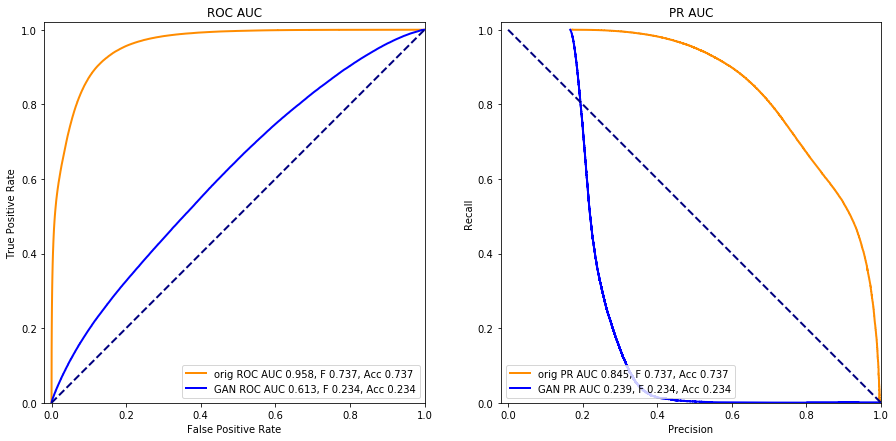

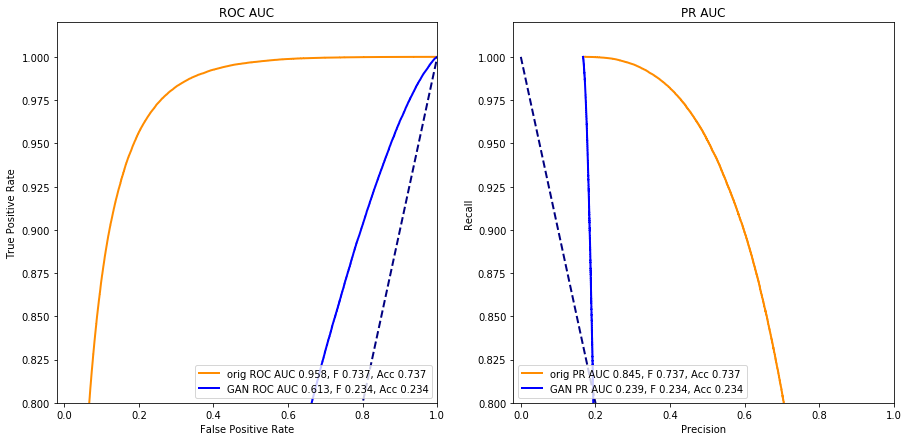

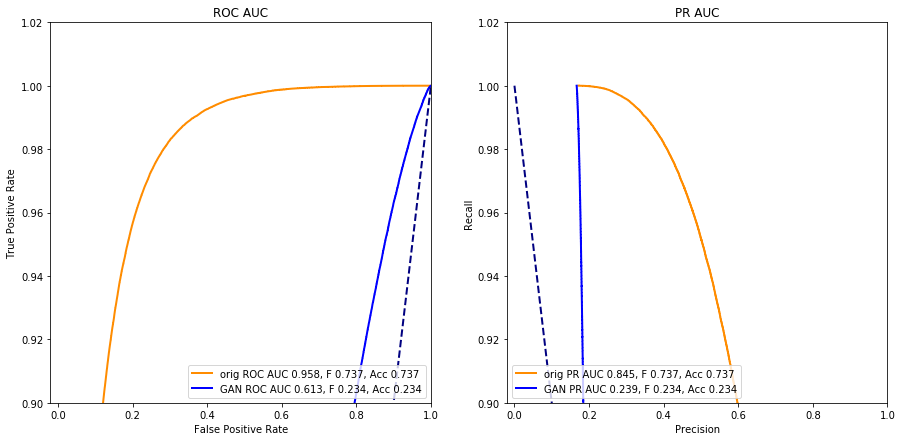

100%|██████████| 2/2 [1:29:30<00:00, 2685.04s/it]


In [46]:
from tqdm import tqdm
for encoding_dim in tqdm(["orig", "GAN"]):
    clf_name = "XGBoost_{}".format(encoding_dim)
    clf = xgb.XGBClassifier(nthread=-1, seed=111)
    
    if encoding_dim == "orig":
        clf.fit(X_train, y_train)
        y_proba = clf.predict_proba(X_test)
        y_bin = label_binarize(y_test, classes=np.unique(y_test))
    else:
        clf.fit(X_train_gen, y_train_gen)
        y_proba = clf.predict_proba(X_test_gen)
        y_bin = label_binarize(y_test_gen, classes=np.unique(y_test_gen))
    y_pred = np.argmax(y_proba, axis=1)
    
    # Compute ROC/PR curve and ROC/PR area for each class
    for pid_label in np.unique(y_test):
        idx = np.where(y_test == pid_label)[0]
        cur_y = np.where(y_test == pid_label, np.ones_like(y_test), np.zeros_like(y_test))
        cur_y_proba = y_proba[:, pid_label]
        
        pid_label = str(pid_label)
        metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], _ = \
            roc_curve(cur_y, cur_y_proba)
        metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], _ = \
            precision_recall_curve(cur_y, cur_y_proba)
        
    metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
        roc_curve(y_bin.ravel(), y_proba.ravel())
    metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
        precision_recall_curve(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
    metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['f_measure'][encoding_dim] = f1_score(y_test, y_pred, average='micro')
    metrics_dict['acc'][encoding_dim] = accuracy_score(y_test, y_pred)
    
    # Save
    dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)
    
    # Plot
    display.clear_output(wait=True)
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.8, 1.02))
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.9, 1.02))

In [ ]:
metrics = load_metrics(path_to_metrics, metrics_dir_name)

In [ ]:
metrics_dict

In [ ]:
plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))